In [300]:
import numpy as np
import mne
from mne import preprocessing

from scipy import signal

import matplotlib.pyplot as plt
from tfld import utils

import pyxdf

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RF
from joblib import delayed, Parallel
from multiprocessing import shared_memory

from tqdm import tqdm
from tfld import tfld


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
dir_ = '/home/azureuser/physionet.org/files/eegmat/1.0.0/'

meta = pd.read_csv(dir_ + 'subject-info.csv')
meta.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [302]:
subject_labels = np.array(list(meta['Count quality']))
gender = np.array(list(meta['Gender']))
recording_year = np.array(list(meta['Recording year']))

raw_edfs = utils.get_raw_edfs(dir_)

raw_edfs = [r.drop_channels(['ECG ECG', 'EEG A2-A1']) for r in raw_edfs]
raw_edfs = [r.rename_channels(lambda x: x.split(' ')[-1]) for r in raw_edfs]
    
montage = mne.channels.make_standard_montage(kind='standard_1020')

infos = [r.set_montage(montage, on_missing='ignore') for r in raw_edfs]
infos = [r.load_data().set_eeg_reference(ref_channels='average') for r in infos]
infos = [r.filter(0.5, 30) for r in infos]

channel_names = np.array(infos[0].ch_names)
print(channel_names)

['Fp1' 'Fp2' 'F3' 'F4' 'F7' 'F8' 'T3' 'T4' 'C3' 'C4' 'T5' 'T6' 'P3' 'P4'
 'O1' 'O2' 'Fz' 'Cz' 'Pz']


In [303]:
from libci.methods import TStoSegmenttoBFtoVec as T1

np.random.seed(1)

channel_inds = np.array([0,1,2,3,4,5,-3,-2])
channel_inds = np.arange(len(channel_names))

n_sessions = len(infos) // 2
bands = [[4,8], [8,12], [12,20]]
sfreq=500
nspw=2.5

windowed = utils.get_time_windows([r.get_data()[channel_inds] for r in infos], sfreq=sfreq, n_seconds_per_window=nspw, n_seconds_overlap=0)
y = [np.concatenate((i * np.ones(windowed[i].shape[0]), (i+1) * np.ones(windowed[i+1].shape[0]))) % 2 for i in range(0, len(windowed), 2)]

windowed = [np.concatenate((windowed[i], windowed[i+1]), axis=0) for i in range(0, len(concat), 2)]
X = [T1(n_segments=1, sfreq=sfreq, bands=bands, pca_components=None, pca_n_elbows=None).fit_transform(w) for w in windowed]

In [304]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

coefs = np.zeros((n_sessions, len(bands) * len(channel_inds)))
ldas = []

for i in range(n_sessions):
    lda = LDA(priors=[0.5, 0.5]).fit(X[i], y[i])
    ldas.append(lda)
    
    coefs[i] = lda.coef_
    
coefs = [c / np.sum(c) for c in coefs]

In [305]:
p=0.2
session_index=0
y_list=y
X_list=X

#- Get rest, active indices
rest_inds = np.where(y_list[session_index] % 2 == 0)[0]
n_train_rest = int(p * len(rest_inds))

active_inds = np.where(y_list[session_index] % 2 == 1)[0]
n_train_active = int(p * len(active_inds))


train_rest_inds = sample_continuous(rest_inds, p=n_train_rest)
train_active_inds = sample_continuous(active_inds, p=n_train_active)

train_inds = np.concatenate((train_rest_inds, train_active_inds))
test_inds = np.array([jj for jj in range(len(X_list[session_index])) if jj not in train_inds])

new_lda = LDA(priors=[0.5, 0.5]).fit(X_list[session_index][train_inds], y_list[session_index][train_inds] % 2)
new_preds = new_lda.predict(X_list[session_index][test_inds])

new_coef_ = new_lda.coef_
new_coef_ /= np.sum(new_coef_)

In [323]:
def get_stratified_train_test_inds(y, p_train=0.8, replace=False):
    unique, counts = np.unique(y, return_counts=True)
    
    n_samples_by_class = [int(np.max([1, np.math.floor(p_train * c)])) for c in counts]
    
    train = []
    
    for i, c in enumerate(unique):
        train.append(np.random.choice(np.where(y == c)[0], size=n_samples_by_class[i], replace=False))
        
    train = np.concatenate(train)
    test = [i for i in range(len(y)) if i not in train]
    
    return train, test

In [298]:
np.random.seed(2)
inds = np.random.choice(len(X[0]), size=int(0.8* len(X[0])), replace=True)

base_coef, bootstrap_ci = bootstrap_feature_importance_interval(X[0][inds], y[0][inds]%2, 1000)

(array([10.,  1.,  6.,  4.,  1.,  8.,  1.,  0.,  4.,  1.]),
 array([0.021 , 0.1137, 0.2064, 0.2991, 0.3918, 0.4845, 0.5772, 0.6699,
        0.7626, 0.8553, 0.948 ]),
 <BarContainer object of 10 artists>)

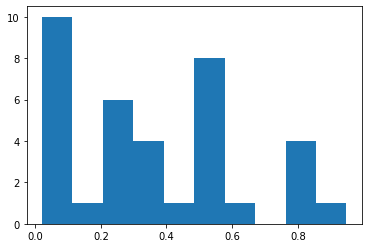

In [299]:
test_statistics = np.linalg.norm(base_coef - np.array(coefs), axis=1)
pvals = np.zeros(len(test_statistics))
for i, t in enumerate(test_statistics):
    pval = np.mean(t <= bootstrap_ci)
    
    if pval == 0:
        pval = 1 / 1000
        
    pvals[i] = pval
    
plt.hist(pvals)

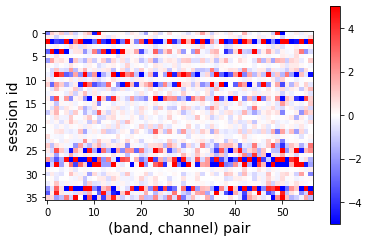

In [266]:
from sklearn.metrics import pairwise_distances
from graspologic.plot import heatmap
from libci.utils import pairplot

from graspologic.embed import ClassicalMDS as CMDS

distances = pairwise_distances(coefs, metric='cosine')
rank_lists = [np.argsort(d)[1:] for d in distances]

plt.imshow(coefs, cmap='bwr', vmin=-5, vmax=5)
plt.xlabel('(band, channel) pair', fontsize=14)
plt.ylabel('session id', fontsize=14)
plt.colorbar()

In [202]:
nn_acc = np.zeros(n_sessions)

for i in range(n_sessions):
    nn_acc[i] = bas(y[i], ldas[rank_lists[i][0]].predict(X[i]))

In [203]:
def sample_continuous(a, p=0.1):
    if p > 1:
        n_sample = p
    else:
        n_sample = int(len(a) * p)
    start_index = np.random.randint(len(a) - n_sample)
    return a[start_index: start_index + n_sample]

In [204]:
def get_random_accuracies(X_list, y_list, session_index, lda_list, k_list, p=0.1):
    assert len(X_list) == len(y_list)

    n_sessions = len(X_list)
    metrics = np.zeros(2*len(k_list)+1)
    
    #- Get rest, active indices
    rest_inds = np.where(y_list[session_index] % 2 == 0)[0]
    n_train_rest = int(p * len(rest_inds))
    
    active_inds = np.where(y_list[session_index] % 2 == 1)[0]
    n_train_active = int(p * len(active_inds))
    
#     min_ = np.min([n_train_active, n_train_rest])
#     n_train_active=min_
#     n_train_rest=min_
    
    train_rest_inds = sample_continuous(rest_inds, p=n_train_rest)
    train_active_inds = sample_continuous(active_inds, p=n_train_active)

    train_inds = np.concatenate((train_rest_inds, train_active_inds))
    test_inds = np.array([jj for jj in range(len(X_list[session_index])) if jj not in train_inds])
    #-
    
    coefs = [lda.coef_[0] for lda in lda_list]
    coefs = [c / np.sum(c) for c in coefs]
    
    
    #- Generate baselines
    models_to_choose_from = [j for j in range(n_sessions) if j != session_index]
    for j, k in enumerate(k_list):
        temp_inds = np.random.choice(models_to_choose_from, size=k, replace=False)
        temp_probas = [lda_list[jj].predict_proba(X_list[session_index][test_inds]) for jj in temp_inds]
        temp_preds = np.argmax(np.average(temp_probas, axis=0), axis=1)
        
        metrics[j] = bas(y_list[session_index][test_inds] % 2, temp_preds)
        
    new_lda = LDA(priors=[0.5, 0.5]).fit(X_list[session_index][train_inds], y_list[session_index][train_inds] % 2)
    new_preds = new_lda.predict(X_list[session_index][test_inds])
    
    new_coef_ = new_lda.coef_
    new_coef_ /= np.sum(new_coef_)

    metrics[len(k_list)] = bas(y_list[session_index][test_inds] % 2, new_preds)
    #-
    
    #- Mahalanobis distance rankings
    distances = np.linalg.norm(new_coef_ - coefs, axis=1)
        
    rank_list = np.argsort(distances)
    
    for j, k in enumerate(k_list):
        inds_to_include = []
        for jj in rank_list:
            if jj != j:
                inds_to_include.append(jj)
            if len(inds_to_include) == k:
                break
        
        temp_probas = [lda_list[jj].predict_proba(X_list[session_index][test_inds]) for jj in inds_to_include]
        temp_preds = np.argmax(np.average(temp_probas, axis=0), axis=1)
        
        metrics[len(k_list) + 1 + j] = bas(y_list[session_index][test_inds] % 2, temp_preds)
    #-
        
    return metrics

In [205]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score as bas
from tqdm import tqdm

np.random.seed(1)

k_list=[1,3,5,10,20, n_sessions-1]
p_list = [0.1, 0.2, 0.3, 0.5, 0.8]
n_mc = 30

balanced_accuracy = np.zeros((n_mc, len(p_list), 2*len(k_list)+1, n_sessions))

for i in tqdm(range(n_sessions)):
    lda_list = [LDA(priors=[0.5, 0.5]).fit(X[j], y[j]) for j in range(n_sessions)]
    
    for j, p in enumerate(p_list):
        f = lambda x: get_random_accuracies(X, y, i, lda_list, k_list, p)
        balanced_accuracy[:, j, :, i] = np.array(Parallel(n_jobs=30)(delayed(f)(_) for _ in np.zeros(n_mc)))

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [01:11<00:00,  1.97s/it]


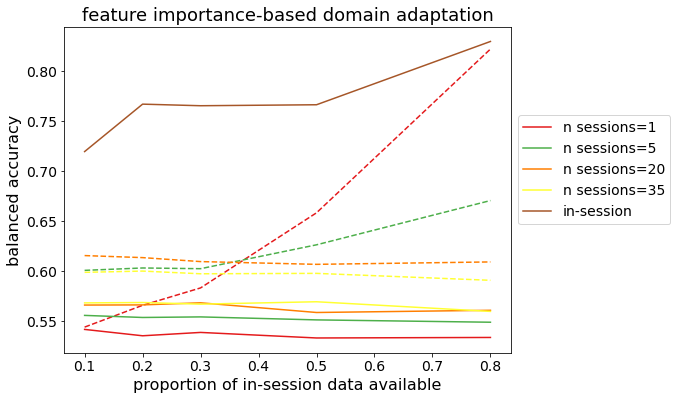

In [206]:
import seaborn as sns

fig, ax= plt.subplots(1,1, figsize=(8,6))
balanced_accuracy_by_person = np.mean(balanced_accuracy, axis=0)
average_balanced_accuracy = np.mean(balanced_accuracy_by_person, axis=-1).T

colors = sns.color_palette("Set1", n_colors=len(k_list)+1)

for i, k in enumerate(k_list):
    if i % 2 ==1 and k != n_sessions-1:
        continue
    ax.plot(p_list, average_balanced_accuracy[i], color=colors[i], label='n sessions=%i'%(k))
    ax.plot(p_list, average_balanced_accuracy[len(k_list) + 1 + i], color=colors[i], ls='--')
#     ax.plot(p_list, (average_balanced_accuracy[len(k_list) + 1 + i] - average_balanced_accuracy[i]) / average_balanced_accuracy[i] , color=colors[i], label='n sessions=%i'%(k))

    
ax.set_ylabel('balanced accuracy', fontsize=16)
ax.set_title('feature importance-based domain adaptation', fontsize=18)
ax.set_xlabel('proportion of in-session data available', fontsize=16)
    
ax.plot(p_list, average_balanced_accuracy[len(k_list)], label='in-session', color=colors[-1])
ax.legend(bbox_to_anchor=(1, 0.75), fontsize=14)
ax.tick_params(labelsize=14)

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:14<00:00,  2.47it/s]


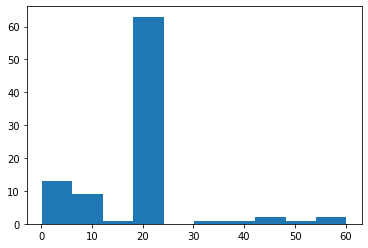

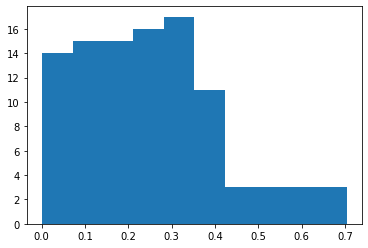

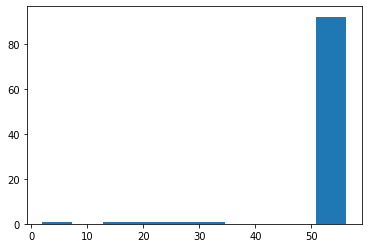

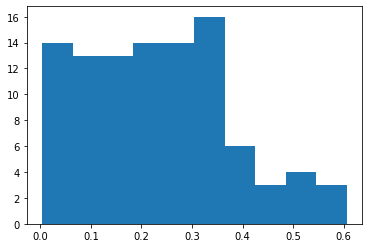

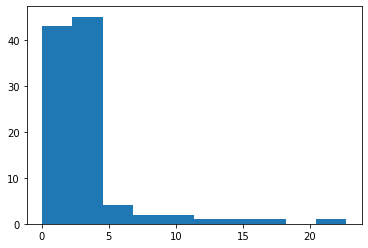

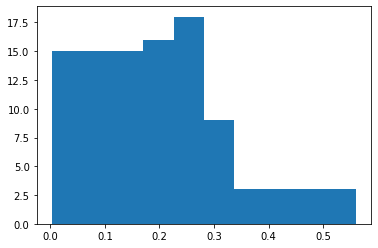

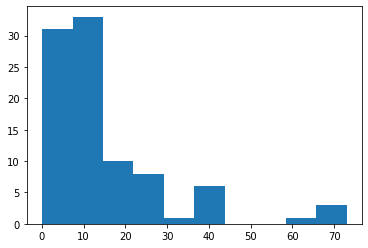

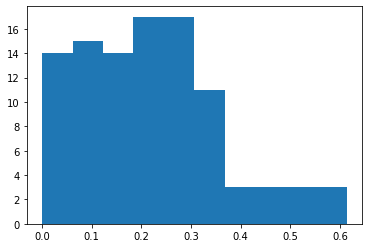

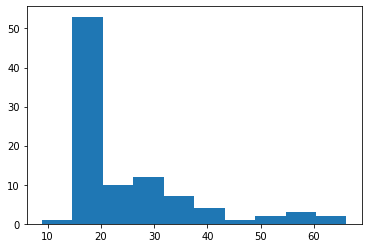

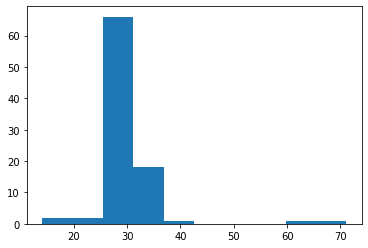

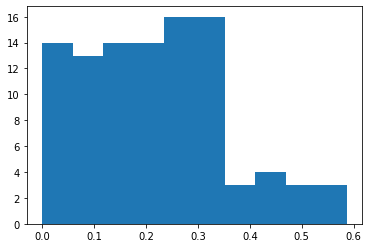

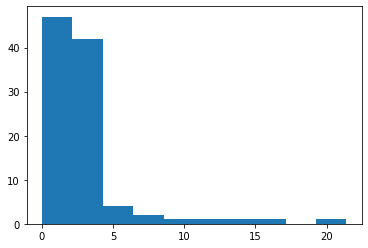

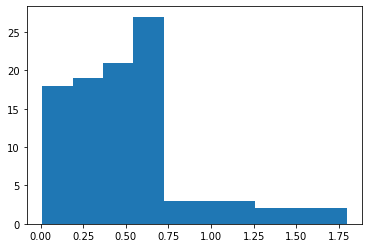

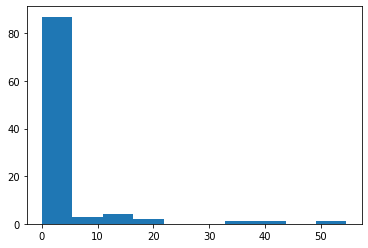

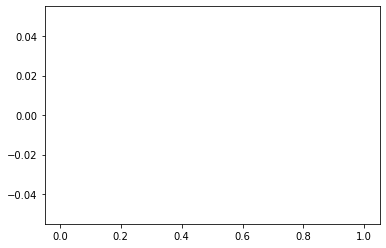

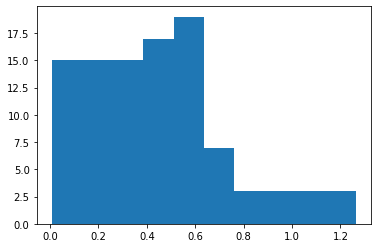

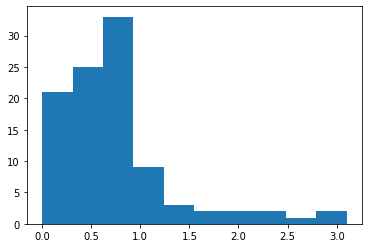

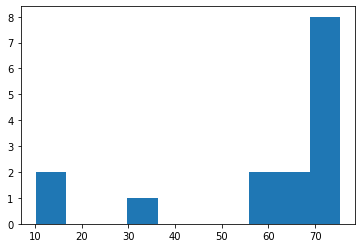

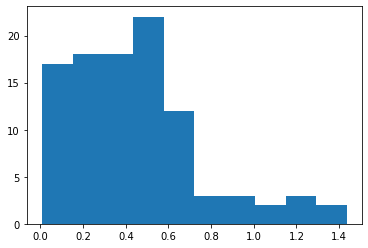

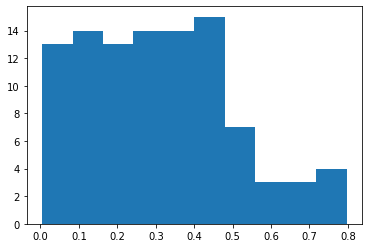

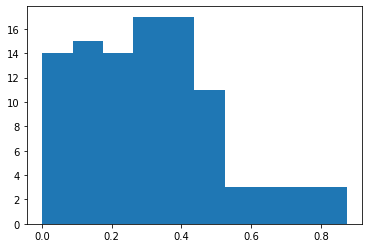

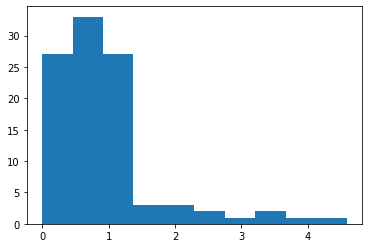

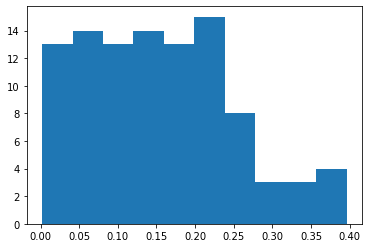

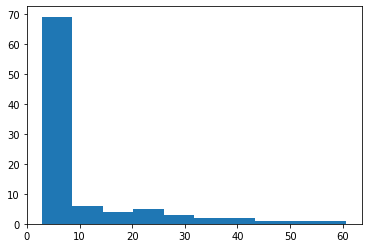

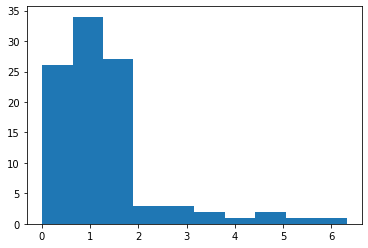

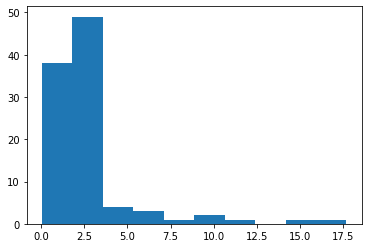

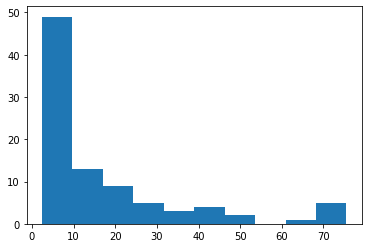

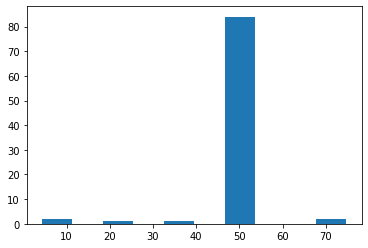

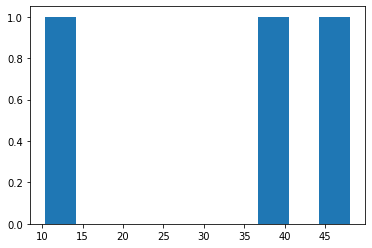

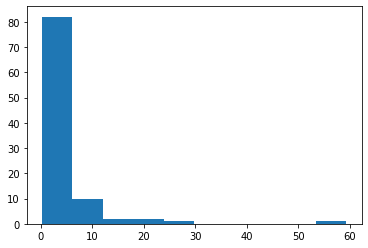

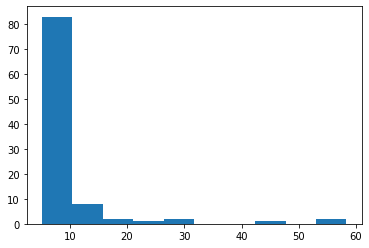

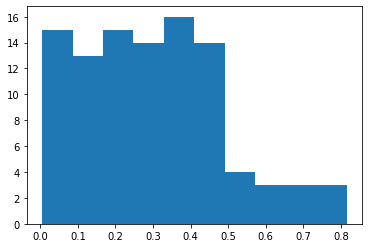

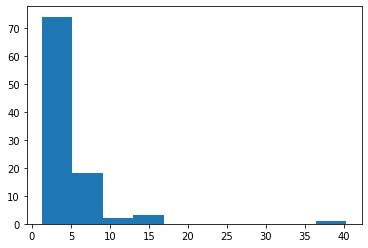

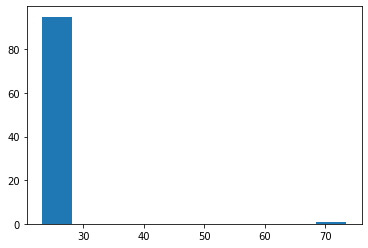

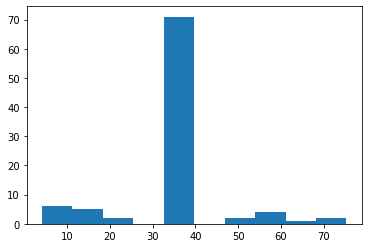

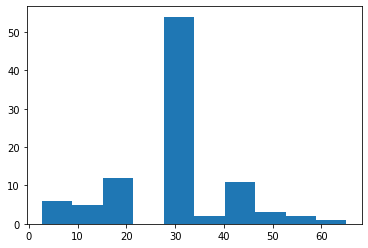

In [345]:
def bootstrap_feature_importance_interval(X, y, n_bootstraps=100):
    len(X) == len(y)
    n, d = X.shape
    
    coefs = np.zeros((n_bootstraps, d))
    for i in range(n_bootstraps):
        inds, _ = get_stratified_train_test_inds(y, p_train=1, replace=True)
        lda = LDA(priors=[0.5, 0.5]).fit(X[inds],y[inds])
        coefs[i] = lda.coef_
        coefs[i] /= np.sum(coefs)
        
    mean_coef = np.mean(coefs, axis=0)
    
        
    return mean_coef, np.linalg.norm(mean_coef - coefs, axis=1)

p_list = [0.8]
n_mc=100

bootstrap_cis = np.zeros((len(p_list), len(X_list), n_mc))

for i, p in enumerate(p_list):
    for j in tqdm(range(n_sessions)):
        inds,_ = get_stratified_train_test_inds(y[j], p_train=1, replace=True)
        temp, bootstrap_cis[i,j] = bootstrap_feature_importance_interval(X[j][inds], y[j][inds]%2, 100)

for i in range(n_sessions):
    fig, ax = plt.subplots(1,1)
    
    max_dist = len(channel_names) * 2 ** 2
    inds = bootstrap_cis[-1,i] < max_dist
    
    ax.hist(bootstrap_cis[0, i, inds])